In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/waste-classification-data


In [ ]:
import os

for dirname, _, filenames in os.walk(path):
    print(dirname)


/kaggle/input/waste-classification-data
/kaggle/input/waste-classification-data/DATASET
/kaggle/input/waste-classification-data/DATASET/TEST
/kaggle/input/waste-classification-data/DATASET/TEST/R
/kaggle/input/waste-classification-data/DATASET/TEST/O
/kaggle/input/waste-classification-data/DATASET/TRAIN
/kaggle/input/waste-classification-data/DATASET/TRAIN/R
/kaggle/input/waste-classification-data/DATASET/TRAIN/O
/kaggle/input/waste-classification-data/dataset
/kaggle/input/waste-classification-data/dataset/DATASET
/kaggle/input/waste-classification-data/dataset/DATASET/TEST
/kaggle/input/waste-classification-data/dataset/DATASET/TEST/R
/kaggle/input/waste-classification-data/dataset/DATASET/TEST/O
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN/R
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN/O


In [ ]:
train_path = path + "/DATASET/TRAIN"
test_path = path + "/DATASET/TEST"


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model  # also changed from vis_utils
from glob import glob


In [ ]:
x_data = []
y_data = []

from tqdm.notebook import tqdm  # For Colab progress bar

for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*'), desc=f'Loading {category.split("/")[-1]}'):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x_data.append(img)
        y_data.append(category.split("/")[-1])


Loading R:   0%|          | 0/9999 [00:00<?, ?it/s]

Loading O:   0%|          | 0/12565 [00:00<?, ?it/s]

In [ ]:
data = pd.DataFrame({
    'image': list(x_data),  # convert to list if it's a NumPy array
    'label': y_data
})

In [ ]:
data.shape

(22564, 2)

In [ ]:
from collections import Counter
Counter(y_data)

Counter({'R': 9999, 'O': 12565})

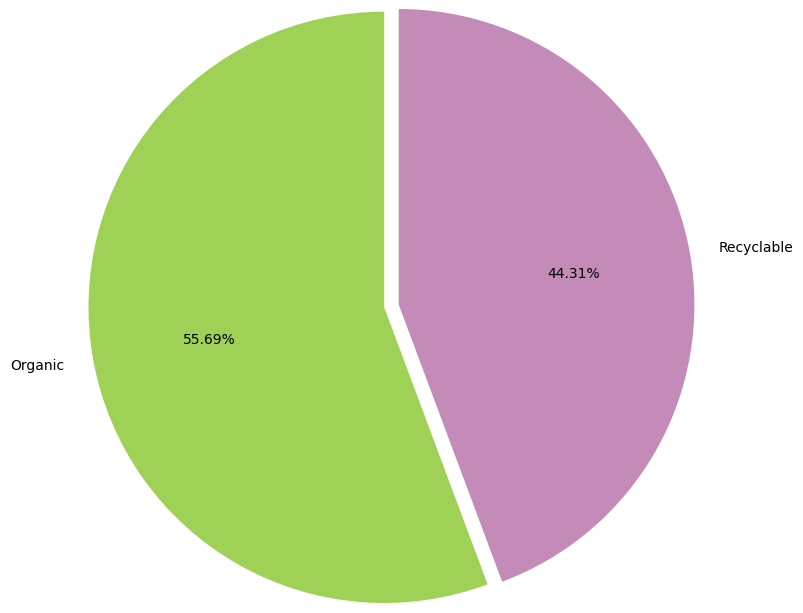

In [ ]:
colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

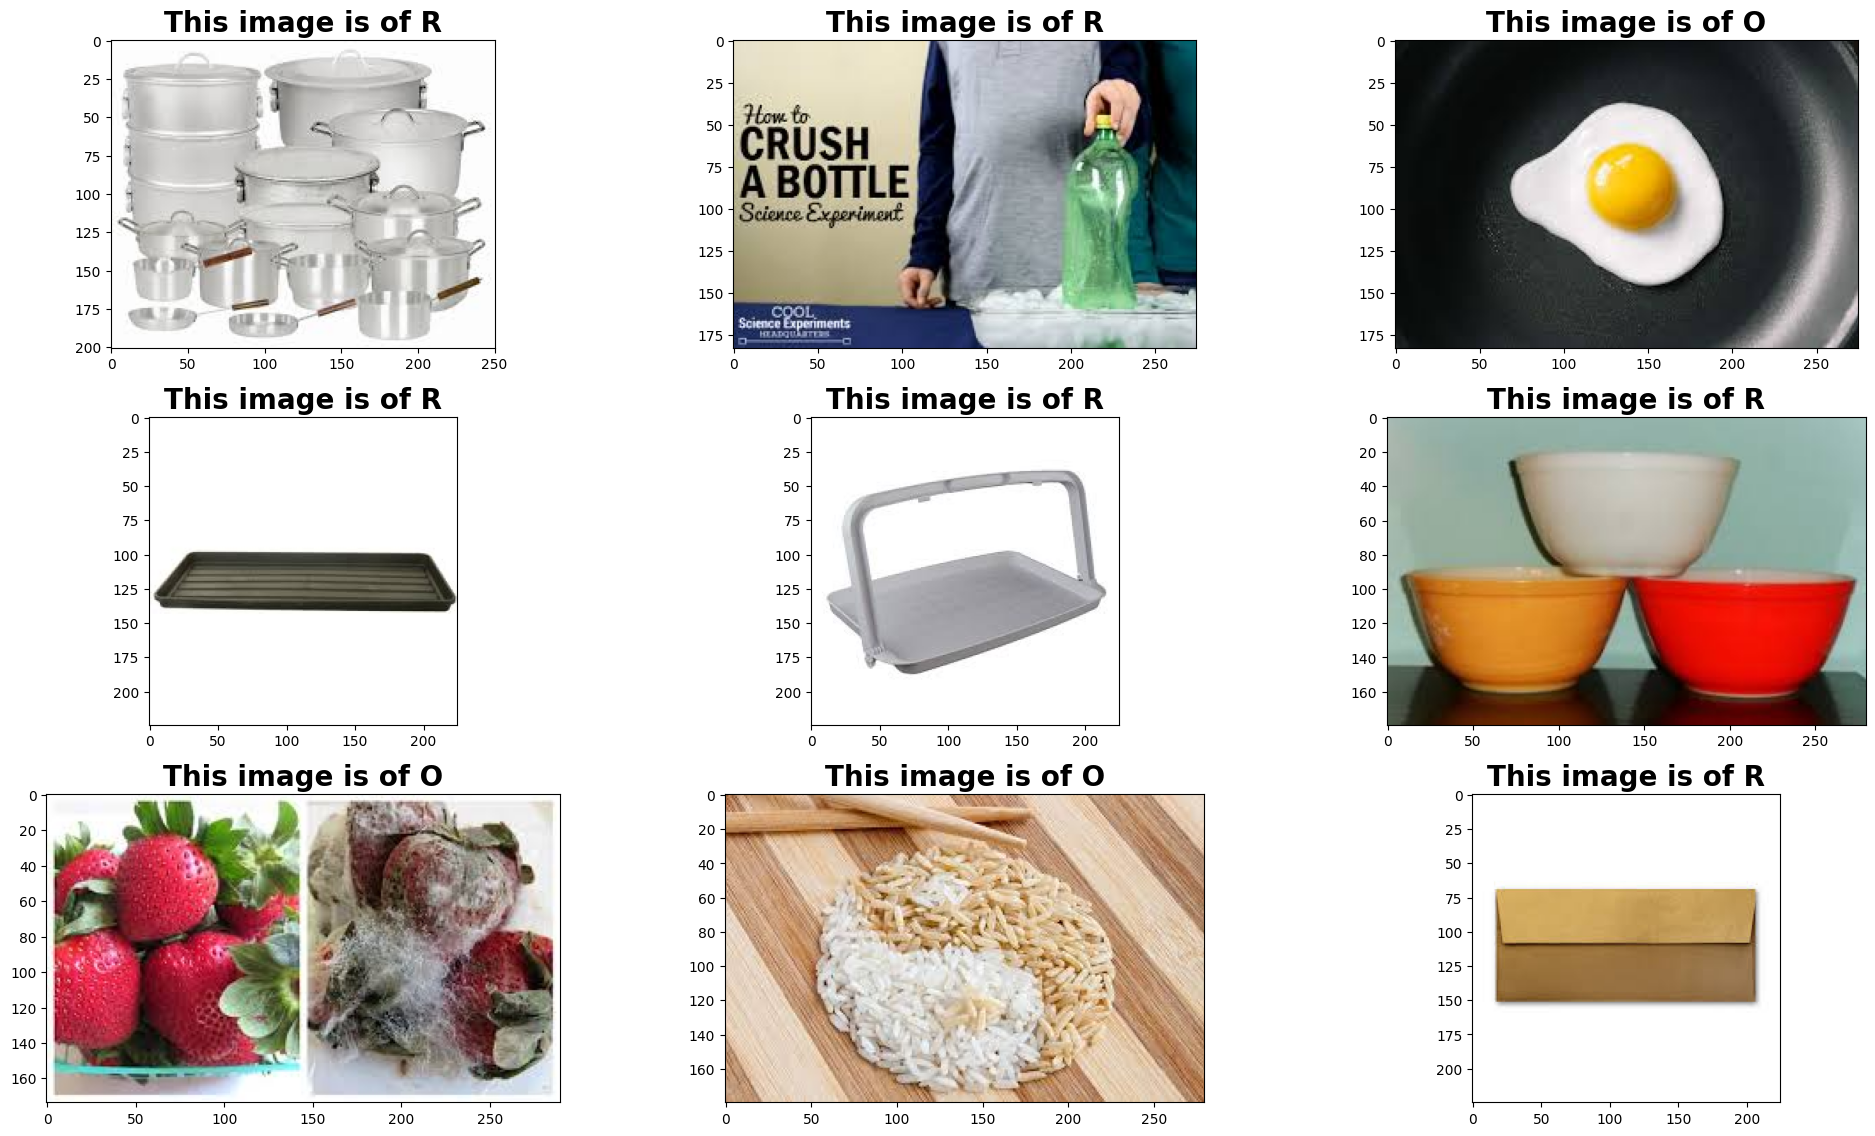

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

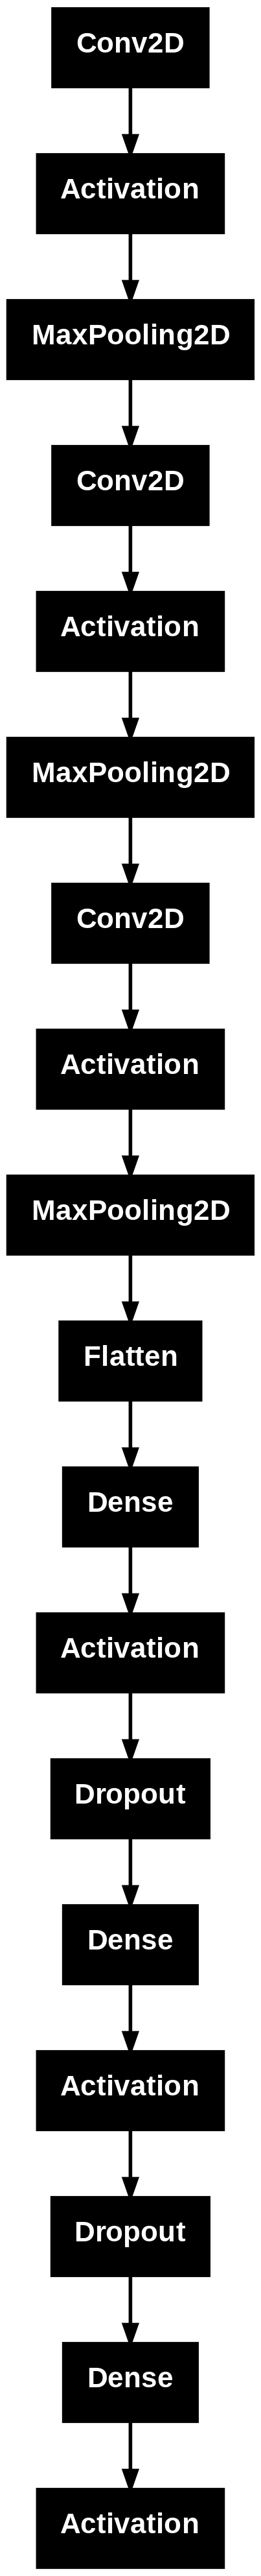

In [ ]:
plot_model(model)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
hist = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator
)


Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 968ms/step - accuracy: 0.7275 - loss: 0.6190 - val_accuracy: 0.8599 - val_loss: 0.3631
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 684ms/step - accuracy: 0.8242 - loss: 0.4104 - val_accuracy: 0.8886 - val_loss: 0.3040
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 681ms/step - accuracy: 0.8447 - loss: 0.3669 - val_accuracy: 0.8456 - val_loss: 0.3558
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 689ms/step - accuracy: 0.8592 - loss: 0.3458 - val_accuracy: 0.8806 - val_loss: 0.3017
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 700ms/step - accuracy: 0.8823 - loss: 0.3072 - val_accuracy: 0.8870 - val_loss: 0.2793


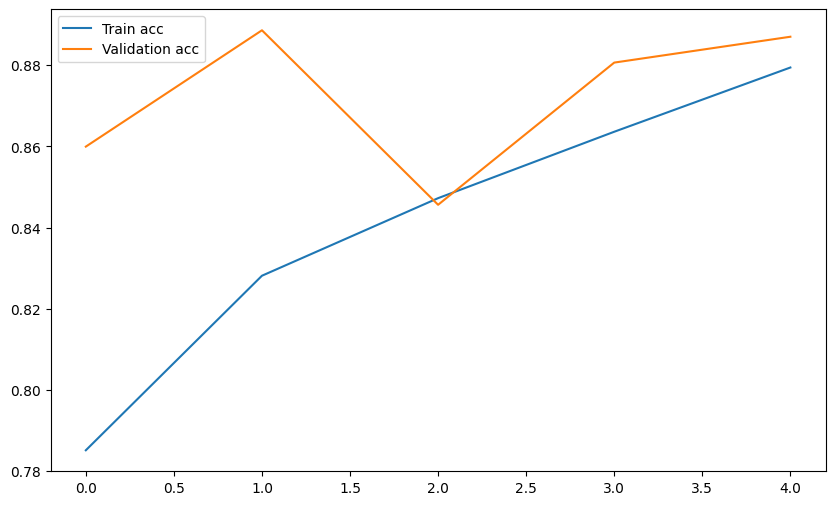

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

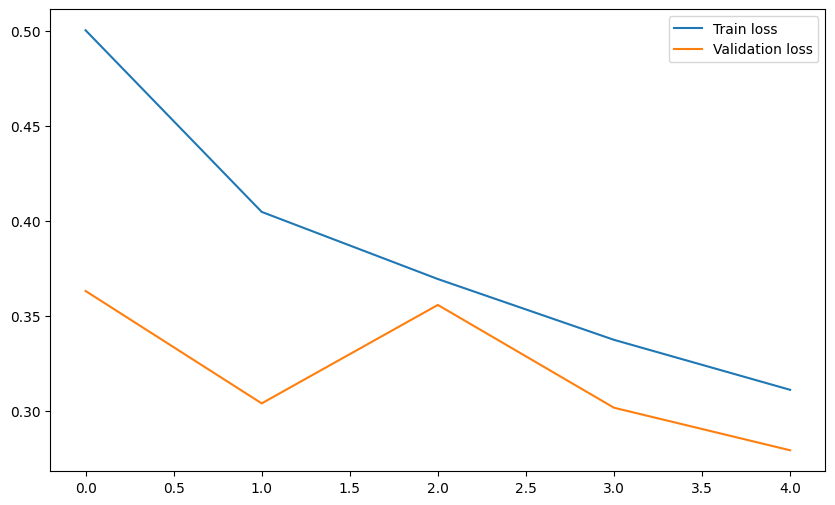

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [ ]:
def predict_func(img):
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")

    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This image -> Organic


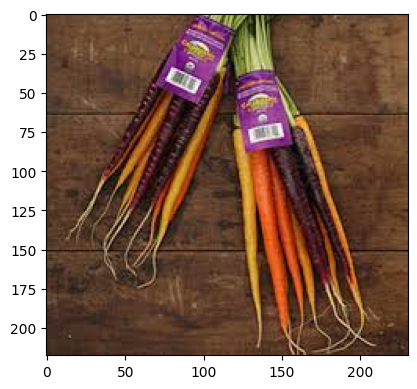

In [ ]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image -> Recyclable


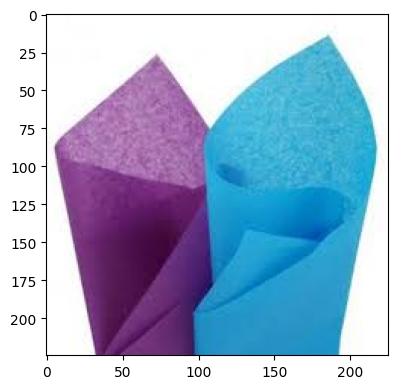

In [ ]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10753.jpg")
predict_func(test_img)

In [ ]:
model.save('waste_classifier_model.keras')


In [ ]:
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model

# Set the page configuration
st.set_page_config(page_title="Waste Classification", layout="wide")

# Load the pre-trained model
model = load_model('waste_classifier_model.keras')

# Define class names (from training)
class_names = ['Recyclable', 'Organic']

# Streamlit UI - Title and Sidebar
st.title("Waste Classification using Deep Learning")
st.sidebar.header("Upload Image")
st.sidebar.markdown("""
    This app predicts if the given image is of **Recyclable** or **Organic** waste.
    Upload your image, and the model will classify it for you!
""")

# Upload image using Streamlit
uploaded_file = st.sidebar.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

# Display image and prediction if the image is uploaded
if uploaded_file is not None:
    # Read the uploaded image
    image = np.array(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # Display the uploaded image
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Make a prediction
    prediction = predict_func(img)
    st.write(f"Prediction: **{prediction}**")

    # Show a pie chart of the prediction
    st.write("### Prediction Confidence Distribution")
    pie_data = [prediction == 'Recyclable', prediction == 'Organic']
    plt.figure(figsize=(6, 6))
    plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', colors=["#a0d157", "#c48bb8"], startangle=90, explode=[0.1, 0.1])
    plt.title(f"Class Distribution for {prediction}")
    st.pyplot(plt)

    # Add a progress bar (for visual feedback)
    with st.spinner("Processing..."):
        st.progress(100)

# Dataset Overview and Exploration
st.header("Explore the Dataset")
st.write("### Dataset Overview")
# Add sample image data (just as a placeholder)
st.image("https://via.placeholder.com/300", caption="Sample Image 1", width=300)
st.image("https://via.placeholder.com/300", caption="Sample Image 2", width=300)
st.image("https://via.placeholder.com/300", caption="Sample Image 3", width=300)

# Optionally, you can display dataset statistics, class distributions, etc.
st.write("### Class Distribution (Organic vs Recyclable)")
# Placeholder for dataset statistics
st.write("Organic waste is generally biodegradable, while recyclable items can be processed into new products.")

# Add some additional insights or information
st.write("""
    ### How it Works:
    - The model has been trained on images of waste items, classifying them into **Recyclable** or **Organic** categories.
    - You can upload any image of waste, and the model will predict its category.
""")

# Show progress bar if the user is interacting with the app
if uploaded_file:
    st.progress(50)


Overwriting app.py


In [ ]:
import threading
def run_streamlit():
    os.system('streamlit run app.py')

threading.Thread(target=run_streamlit).start()

In [ ]:
!ngrok config add-authtoken 2w0CPjMCVxwjsWj2d0UhSxM4Xqx_6LyQqLh6eG7q5gq1s936C

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Start a tunnel to port 8501 for Streamlit (or 5000 for Flask)
public_url = ngrok.connect(8501)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://33b7-34-16-197-182.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!pkill -f streamlit
!pkill -f ngrok


In [ ]:
 A total of 2 objects could not be loaded. Example error message for object <Dense name=dense, built=True>: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized. List of objects that could not be loaded: [<Dense name=dense, built=True>, <keras.src.optimizers.adam.Adam object at 0x79b779091f10>]
Traceback:
File "/content/app.py", line 8, in <module>
    model = load_model('waste_classifier_model.keras')
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py", line 189, in load_model
    return saving_lib.load_model(
           ^^^^^^^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py", line 367, in load_model
    return _load_model_from_fileobj(
           ^^^^^^^^^^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py", line 509, in _load_model_from_fileobj
    _raise_loading_failure(error_msgs)
File "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py", line 631, in _raise_loading_failure
    raise ValueError(msg)